In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import os
import gc
import sys

import wandb

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

INF = sys.maxsize

In [5]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [6]:
wandb.login(key='')
run = wandb.init(project='flower_classifier', name='training')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/kimhongseok/.netrc


# Data 확인

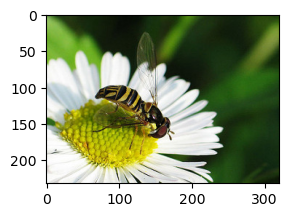

2729

In [7]:
root_dir = '/Users/kimhongseok/upstage_AI_Lab/practice/pytorch/CNN/flower_photos'

test_img = Image.open(os.path.join(root_dir, 'daisy/5547758_eea9edfd54_n.jpg'))

plt.figure(figsize=(3,3))
plt.imshow(test_img)
plt.show()

del test_img
gc.collect()

# CustomDataset

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms, classes):
        super().__init__()
        self.root_dir = root_dir
        self.transforms = transforms
        self.data = list()

        for label, cls in enumerate(classes):
            class_dir = os.path.join(self.root_dir, cls)
            dir_list = os.listdir(class_dir)
            for img in dir_list:
                self.data.append((os.path.join(class_dir, img), label))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.transforms(Image.open(self.data[idx][0]))
        label = self.data[idx][1]
        return image, label

In [11]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224))
])

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

dataset = CustomDataset(root_dir, transforms, classes)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


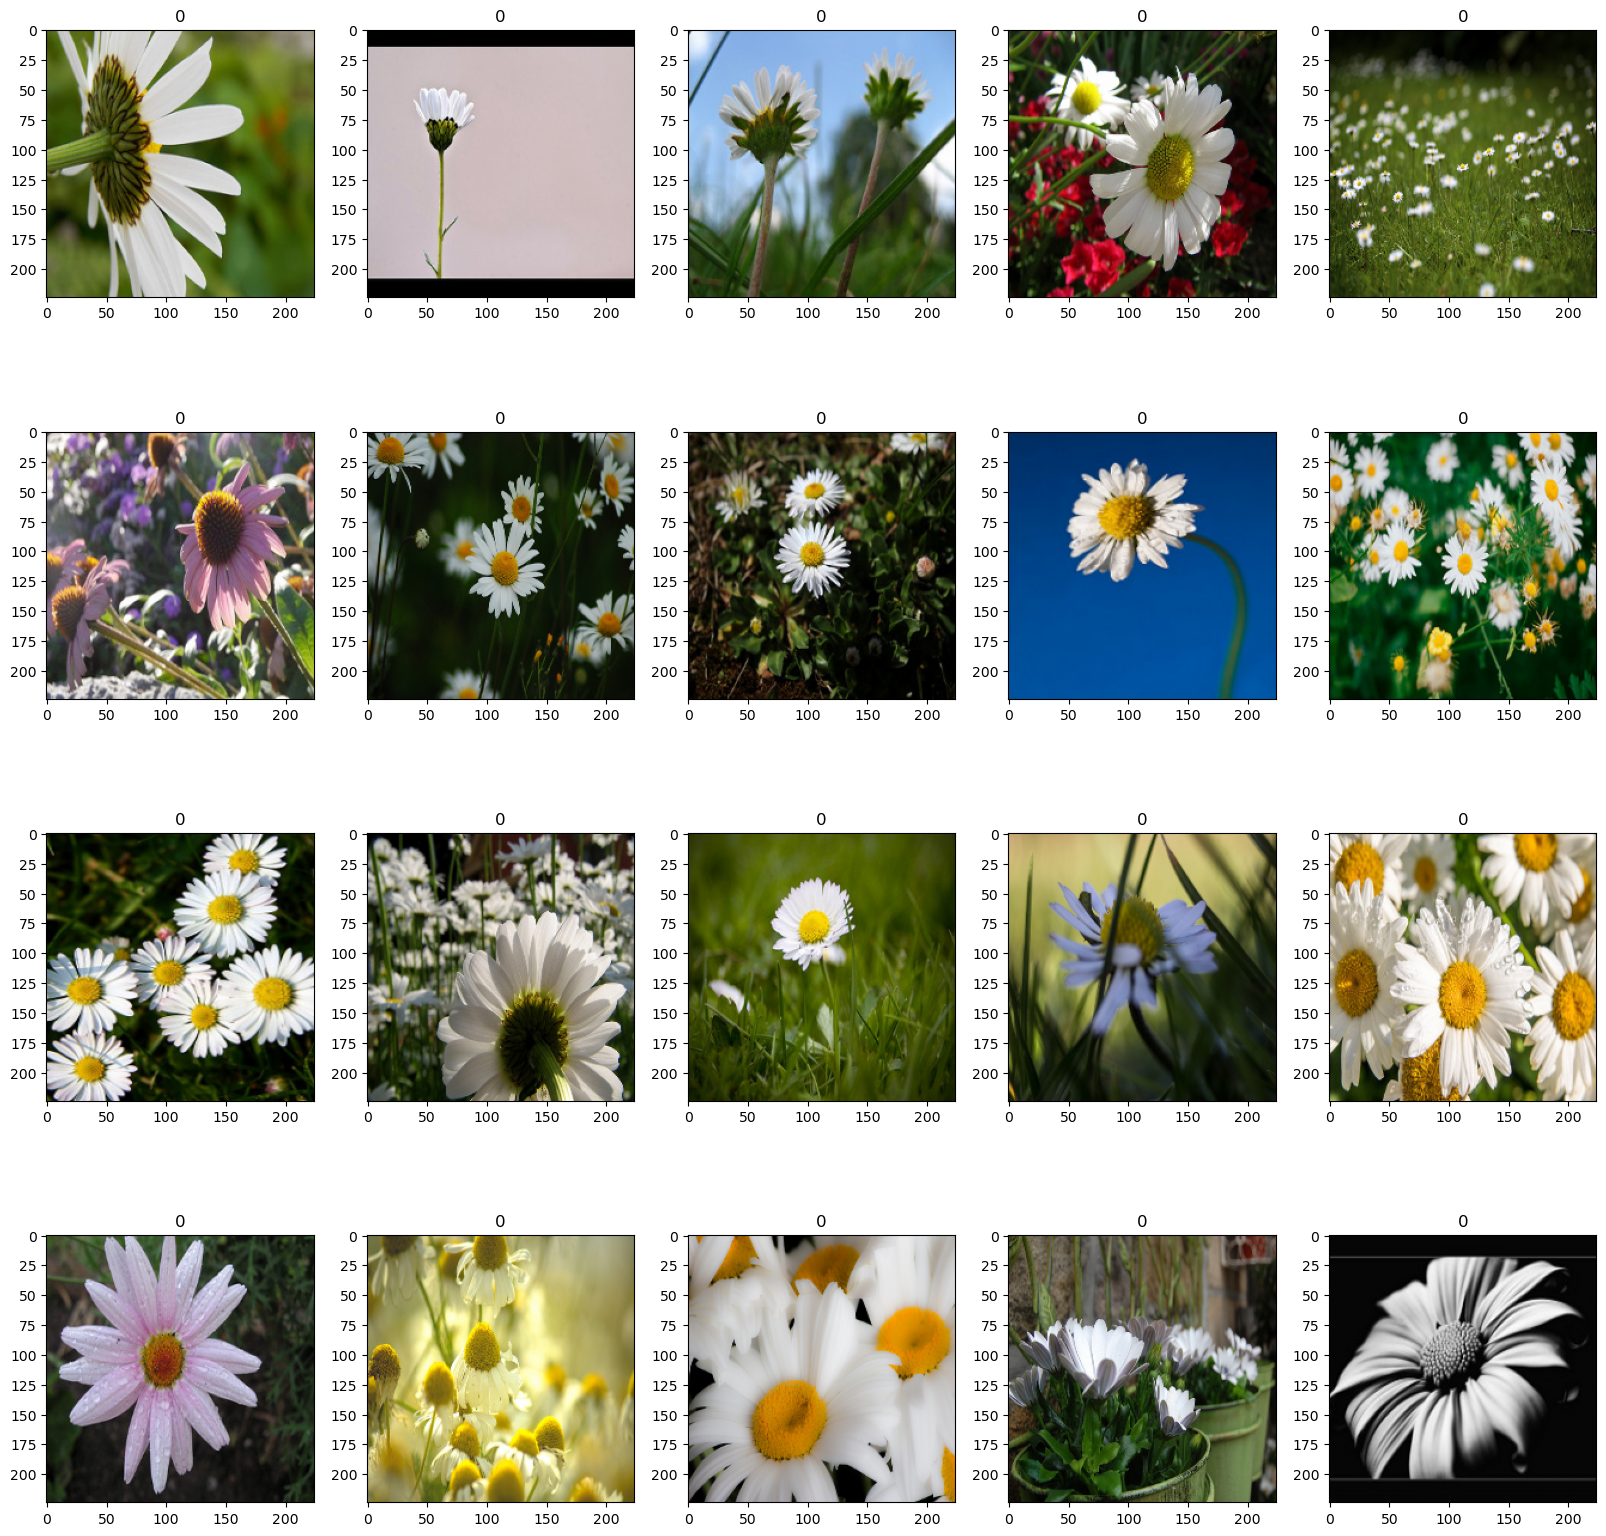

In [12]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(dataset[i][0].permute((1, 2, 0))))
    plt.title(dataset[i][1])

In [13]:
total_num = len(dataset)
train_num = int(total_num * 0.7)
valid_num = int(total_num * 0.1)
test_num = int(total_num * 0.2)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_num, valid_num, test_num])

# DataLoader

In [14]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([3, 3, 2, 0, 1, 2, 1, 2, 3, 3, 4, 2, 3, 1, 3, 2, 2, 2, 4, 0, 3, 0, 0, 1,
        1, 1, 2, 4, 2, 3, 1, 1])


# Model

In [16]:
class torch_CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=224*224*32, out_features=5),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        output = self.layer(x)
        return output

In [17]:
torch_model = torch_CNN()

In [18]:
summary(torch_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 224, 224]               0
            Conv2d-5         [-1, 32, 224, 224]           4,640
       BatchNorm2d-6         [-1, 32, 224, 224]              64
              ReLU-7         [-1, 32, 224, 224]               0
         MaxPool2d-8         [-1, 32, 224, 224]               0
           Flatten-9              [-1, 1605632]               0
           Linear-10                    [-1, 5]       8,028,165
       LogSoftmax-11                    [-1, 5]               0
Total params: 8,033,349
Trainable params: 8,033,349
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forw

# Traininig

In [19]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (labels == predicted).sum().item()

            tbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Valid loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = INF
    best_valid_accuracy = -1
    early_stop_cnt = 0

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        monitoring_value = {'train_loss': train_loss, 'train_accuracy': train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}
        run.log(monitoring_value, step=epoch)

        if valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

        if early_stop_cnt > 2:
            print('Early Stopping')
            break

    return model, best_valid_accuracy, best_valid_loss

In [20]:
num_epochs = 100

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)

model, best_valid_accuracy, best_valid_loss = training_loop(torch_model, train_dataloader, valid_dataloader, train_dataset, valid_dataset, criterion, optimizer, num_epochs)

  0%|          | 0/81 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 258.2625, Train Accuracy: 0.3624 Valid Loss: 71.2584, Valid Accuracy: 0.4823


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 74.8753, Train Accuracy: 0.5247 Valid Loss: 81.3756, Valid Accuracy: 0.4959


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 53.4224, Train Accuracy: 0.5944 Valid Loss: 101.8394, Valid Accuracy: 0.4578


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 47.9376, Train Accuracy: 0.6399 Valid Loss: 135.9807, Valid Accuracy: 0.3597
Early Stopping


# Test

In [21]:
test_loss = 0.0
test_accuracy = 0

model.eval()
with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_accuracy += (labels == predicted).sum().item()

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

print(test_loss)
print(test_accuracy)

  0%|          | 0/23 [00:00<?, ?it/s]

134.1861456166143
0.3555858310626703
